# Fitting Tutorial

Below is a basic exercise in fitting a quadratic polynomial to some noisy data, done using many different fitting packages to demonstrate their basic usage.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(0)

## The True Model (and Data Generation)

In [2]:
def model(x, a, b, c):
    '''The model we are fitting.'''
    return a*x**2 + b*x + c

x = np.linspace(-5, 5, 256)
SIG_N = 1
prms_true = (1.1, 2.2, 3.3)
y_meas = model(x, *prms_true) + SIG_N * np.random.normal(size=x.shape)

In [3]:
def report(prms):
    '''Generate a pretty report and plot for a set of parameters.'''
    if type(prms) == dict:
        prms = (prms['a'], prms['b'], prms['c'])
    if type(prms[0]) != float:
        prms = tuple(float(p) for p in prms)
    y = model(x, *prms)
    chisq = np.sum(np.abs(y_meas - y)**2 / SIG_N**2)
    chisq_r = chisq / (y_meas.size - len(prms))
    print(f'A:{prms[0]:7.3}, B:{prms[1]:7.3}, C:{prms[2]:7.3}')
    print(f'Chi-sq: {chisq:7.3}, Reduced Chi-sq: {chisq_r:7.3}')

    plt.figure()
    plt.plot(x, y_meas, '.', label='measured')
    plt.plot(x, y, label='model')
    plt.plot(x, y_meas - y, label='residual')
    plt.grid()
    _ = plt.legend()

A:    1.1, B:    2.2, C:    3.3
Chi-sq: 2.5e+02, Reduced Chi-sq:   0.988


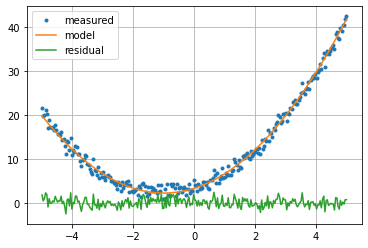

In [4]:
report(prms_true)

# Fitting

## numpy.linalg.lstsq

A:    1.1, B:   2.17, C:   3.34
Chi-sq: 2.48e+02, Reduced Chi-sq:    0.98


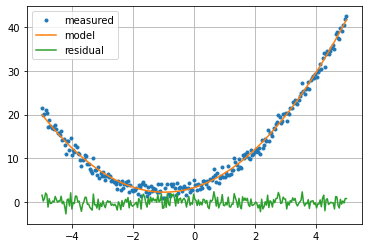

In [5]:
# np.linalg.lstsq
# generic matrix-based linear chi-sq optimizer
A = np.array([x**2, x, np.ones_like(x)]).T  # design matrix
prms_opt, res2, rank, s = np.linalg.lstsq(A, y_meas, rcond=None)
report(prms_opt)

## numpy.polyfit

A:    1.1, B:   2.17, C:   3.34
Chi-sq: 2.48e+02, Reduced Chi-sq:    0.98


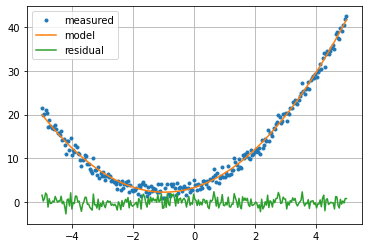

In [6]:
# np.polyfit
# special case of matrix-based linear chi-sq optimizer for polynomials
prms_opt = np.polyfit(x, y_meas, deg=2)
report(prms_opt)

##  scipy.optimize.fmin

Optimization terminated successfully.
         Current function value: 247.892740
         Iterations: 134
         Function evaluations: 248
A:    1.1, B:   2.17, C:   3.34
Chi-sq: 2.48e+02, Reduced Chi-sq:    0.98


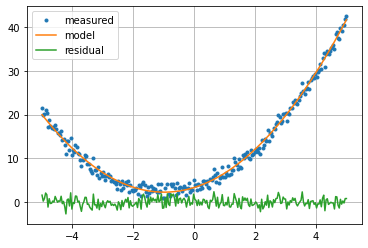

In [7]:
from scipy.optimize import fmin

def my_chisq(prms, x, y_meas, sig_n=1):
    return np.sum(np.abs(model(x, *prms) - y_meas)**2 / sig_n**2)

# scipy.optimize.fmin
# very generic function optimization, guesses gradient from serial function evaluations
init_guess = np.array([0.1, 0.1, 0.1])
prms_opt, chisq_min, niter, ncalls, flags = fmin(my_chisq, init_guess, (x, y_meas, SIG_N), full_output=True)
report(prms_opt)

## scipy.optimize.curve_fit

A:    1.1, B:   2.17, C:   3.34
Chi-sq: 2.48e+02, Reduced Chi-sq:    0.98


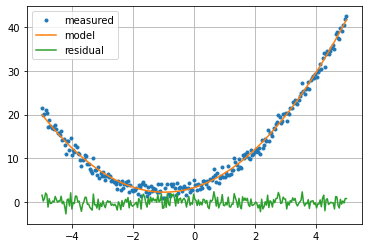

In [8]:
# scipy.optimize.curve_fit
from scipy.optimize import curve_fit

# generic function optimization via least-squares, guesses gradient from serial function evaluations
init_guess = np.array([0.1, 0.1, 0.1])
prms_opt, cov, info, msg, flag = curve_fit(model, x, y_meas, init_guess, SIG_N * np.ones_like(y_meas), full_output=True)
report(prms_opt)

## linsolve

A:    1.1, B:   2.17, C:   3.34
Chi-sq: 2.48e+02, Reduced Chi-sq:    0.98


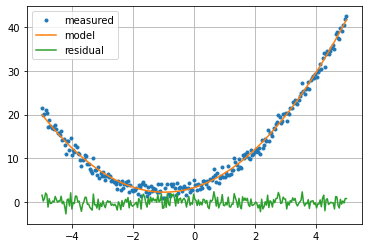

In [9]:
# linsolve interface to np.linalg.lstsq
import linsolve

data = {f'a*{xi**2}+b*{xi}+c': yi for xi, yi in zip(x, y_meas)}
ls = linsolve.LinearSolver(data)
prms_opt = ls.solve()
report(prms_opt)

## jax (and optax)

Note that (for now) <tt>optax</tt> does not support complex numbers (it fails silently), so build complex numbers inside jax from real-valued optax parameters.

In [10]:
import jax
import jax.numpy as jnp
import optax

def sim(prms, args):
    x, _, _ = args
    return prms['a'] * x**2 + prms['b'] * x + prms['c']

@jax.jit
def calc_loss(prms, args):
    _, y_meas, sig_n = args
    loss = jnp.sum(jnp.abs(y_meas - sim(prms, args))**2 / sig_n**2)
    return loss

def fit(optimizer, prms, args, maxiter=150, print_every=100, target_loss=1):
    opt_state = optimizer.init(prms)
    
    def step(opt_state, prms, args):
        loss, grads = jax.value_and_grad(calc_loss)(prms, args)
        updates, opt_state = optimizer.update(grads, opt_state, prms)
        prms = optax.apply_updates(prms, updates)
        return prms, opt_state, loss, grads
    
    for i in range(maxiter):
        prms, opt_state, loss, grads = step(opt_state, prms, args)
        if i % print_every == 0 or i == maxiter-1 or loss < target_loss:
            print(f'step {i:04d}, loss: {loss:9.7f}')
        if loss < target_loss:
            break
    return prms, loss, grads

2024-09-09 16:38:36.587630: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


step 0000, loss: 5923.0439453
step 0100, loss: 2155.2182617
step 0200, loss: 774.0867920
step 0300, loss: 336.8463135
step 0394, loss: 248.7247467
A:   1.11, B:   2.17, C:   3.26
Chi-sq: 2.49e+02, Reduced Chi-sq:   0.984


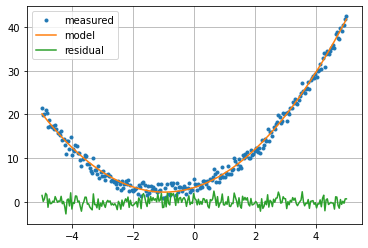

In [11]:
prms = {'a': jnp.asarray([1.0]), 'b': jnp.asarray([1.0]), 'c': jnp.asarray([1.0])}
optimizer = optax.lamb(learning_rate=3e-3)
prms_opt, chisq_min, _ = fit(optimizer, prms, (x, y_meas, SIG_N), maxiter=500, target_loss=y_meas.size-len(prms)-4)
report(prms_opt)

# Markov Chain Monte Carlo (MCMC) methods

The approaches below all use MCMC methods to converge toward the Bayesian posterior. MCMC methods tend to be slower to converge than gradient-based methods, but they have the advantage of exploring around the maximum likelihood solution to explicitly examine the posterior probability (e.g. final error bars) of fit parameters.

In [12]:
import corner
import tqdm

prm_order = ['a', 'b', 'c', 'logsig']
nprms = len(prm_order)

## pymc

<tt>pymc</tt> is a relatively batteries-included MCMC package. Running it is pretty simple, but beware that the way a chain is set up relies implicitly on class instantiation, making its evaluation a little hard for a reader to follow. 

In [13]:
import pymc

def run_mcmc(x, y_meas):
    with pymc.Model() as mdl:
        a = pymc.Uniform('a', -5, 5)
        b = pymc.Uniform('b', -5, 5)
        c = pymc.Uniform('c', -5, 5)
        logsig = pymc.Uniform('logsig', -1.0, 1.0)
        y_err = 10**logsig
        yhat = model(x, a, b, c)
        likelihood = pymc.Normal("y", mu=yhat, sigma=y_err, observed=y_meas)
        return pymc.sample(2_000, tune=200)

chain = run_mcmc(x, y_meas)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, c, logsig]


Output()

Sampling 4 chains for 200 tune and 2_000 draw iterations (800 + 8_000 draws total) took 6 seconds.


Text(0.5, 0, 'Step')

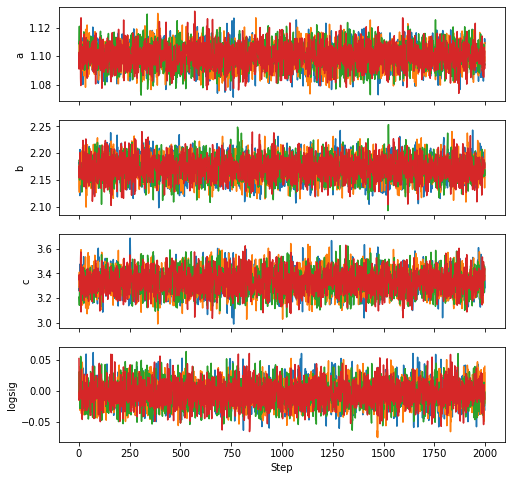

In [14]:
fig, axes = plt.subplots(nrows=nprms, sharex=True, figsize=(8,8))
for i, k in enumerate(prm_order):
    axes[i].plot(chain.posterior[k].T)
    axes[i].set_ylabel(k)
axes[nprms-1].set_xlabel('Step')

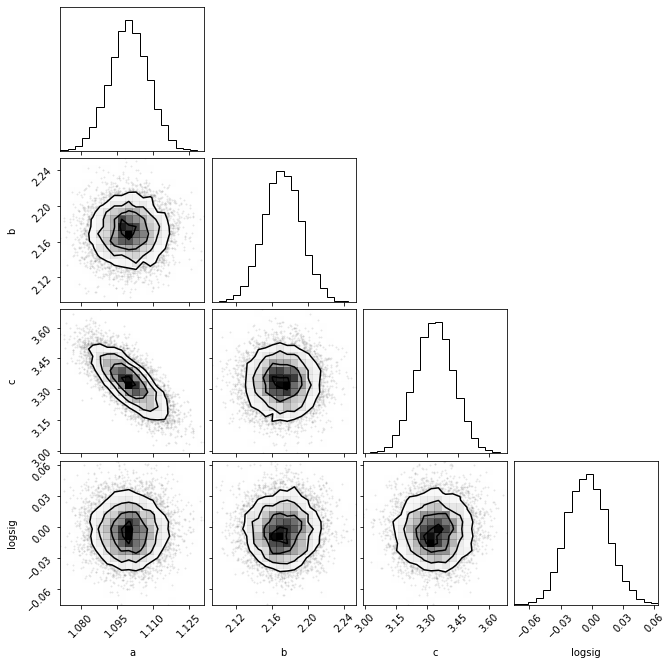

In [15]:
_ = corner.corner(chain)

Inferred noise sigma:   0.991
A:    1.1, B:   2.17, C:   3.34
Chi-sq: 2.48e+02, Reduced Chi-sq:    0.98


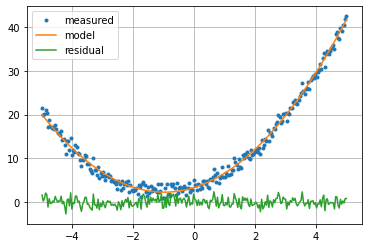

In [16]:
prms_opt = {k: np.mean(chain.posterior[k]) for k in prm_order}
sig_n = 10**prms_opt.pop('logsig')
print(f'Inferred noise sigma: {sig_n:7.3}')
report(prms_opt)

## emcee

<tt>emcee</tt> requires more explicit programming, which makes it harder to use but easier to read/control. Note the custom classes created here to handle priors more cleanly.

In [17]:
import emcee

class Uniform:
    '''Model a flat (uniform) prior of a variable.'''
    def __init__(self, name, lower, upper):
        self.name = name
        self.lower = lower
        self.upper = upper
    def start_val(self):
        return np.random.uniform(self.lower, self.upper)
    def log_prior(self, val):
        if self.lower < val < self.upper:
            return 0.0
        else:
            return -np.inf
        
class Normal:
    '''Model a normal (gaussian distributed) prior of a variable.'''
    def __init__(self, name, mean, sigma):
        self.name = name
        self.mean = mean
        self.sigma = sigma
    def start_val(self):
        return self.mean + self.sigma * np.random.normal()
    def log_prior(self, val):
        return -0.5*(np.log(2 * np.pi * self.sigma**2) + np.abs(val - self.mean)**2 / self.sigma**2 )
        
        
prms = {
    'a': Uniform('a', lower=-5, upper=5),
    'b': Uniform('b', lower=-5, upper=5),
    'c': Uniform('c', lower=-5, upper=5),
    'logsig': Uniform('logsig', lower=-1.0, upper=1.0),
}
        
def log_prior(**kwargs):
    return sum([prms[k].log_prior(v) for k, v in kwargs.items()])

def log_likelihood(y, yhat, sig_noise):
    L = -0.5 * (np.log(2 * np.pi * sig_noise**2) + np.abs(y - yhat)**2 / sig_noise**2 )
    return np.sum(L)

def log_probability(prms, x, y_meas):
    a, b, c, logsig = prms
    prms = dict(zip(prm_order, prms))
    lp = log_prior(**prms)
    if not np.isfinite(lp):
        return -np.inf
    yhat = model(x, a, b, c)
    return lp + log_likelihood(y_meas, yhat, 10**logsig)

nwalkers = 12
sol0 = np.array([[prms[k].start_val() for _ in range(nwalkers)] for k in prm_order]).T

sampler = emcee.EnsembleSampler(nwalkers, nprms, log_probability, args=(x, y_meas))
sampler.run_mcmc(sol0, 2500, progress=True);

100%|█████████████████████████████████████| 2500/2500 [00:01<00:00, 1478.68it/s]


Text(0.5, 0, 'Step')

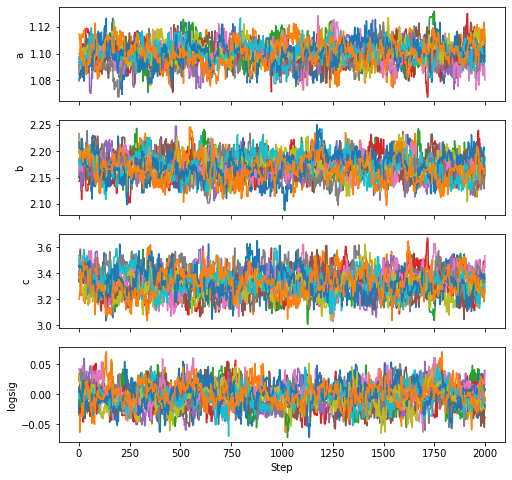

In [18]:
# Note in emcee that we have to explicitly discard the early "burn-in" samples of a chain.
trace = sampler.get_chain(discard=500)
trace = dict(zip(prm_order, trace.T))

fig, axes = plt.subplots(nrows=nprms, sharex=True, figsize=(8,8))
for i, k in enumerate(prm_order):
    axes[i].plot(trace[k].T)
    axes[i].set_ylabel(k)
axes[nprms-1].set_xlabel('Step')

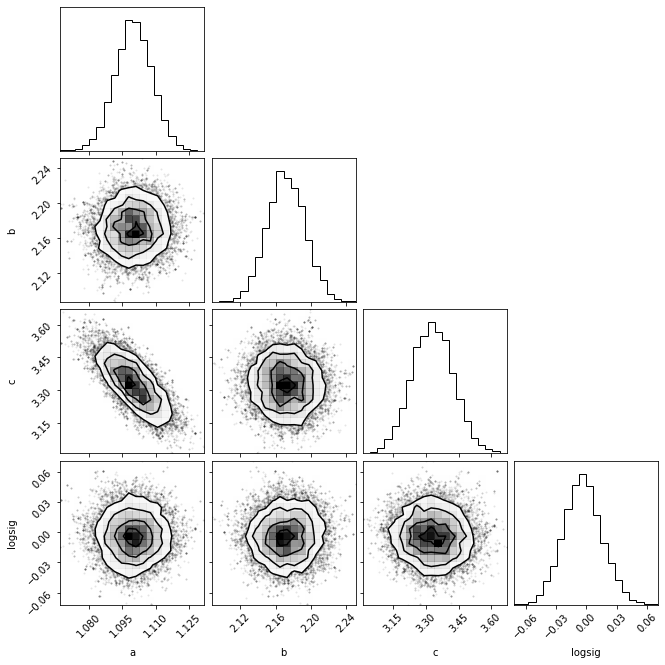

In [19]:
_ = corner.corner(trace)

Inferred noise sigma:   0.992
A:    1.1, B:   2.17, C:   3.33
Chi-sq: 2.48e+02, Reduced Chi-sq:    0.98


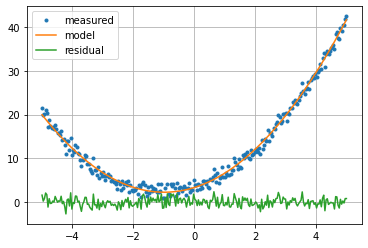

In [20]:
prms_opt = {k: np.mean(trace[k]) for k in prm_order}
sig_n = 10**prms_opt.pop('logsig')
print(f'Inferred noise sigma: {sig_n:7.3}')
report(prms_opt)

## manual MCMC

A final (not recommended) option is to code your own MCMC walker. Some of the code for this was already built above for <tt>emcee</tt>, so we just need to add the Metropolis-Hastings stepper to make it work. However, it is very finicky about step sizes, burn-in, and correlation between steps, making it substantially inferior to most modern MCMC packages. It does, however, illustrate the basics of how MCMC works.

In [21]:
def _metropolis_hastings_step(current, step_size):
    proposed = current + np.random.normal(scale=step_size, size=current.size)
    acceptance_ratio = np.exp(log_probability(proposed, x, y_meas) - log_probability(current, x, y_meas))
    if np.random.uniform() < acceptance_ratio: 
        current = proposed
    return current

def metropolis_hastings(n_steps, n_burnin, step_size, prms):
    current = np.array([prms[k].start_val() for k in prm_order])
    chain = []
    for _ in range(n_burnin - 1):
        current = _metropolis_hastings_step(current, step_size)
    for _ in tqdm.tqdm(range(n_steps)):
        current = _metropolis_hastings_step(current, step_size)
        chain.append(current)
    chain = dict(zip(prm_order, np.array(chain).T))
    return chain

chain = metropolis_hastings(12000, 6200, 0.02, prms)

/tmp/ipykernel_100950/967969527.py:3: RuntimeWarning: overflow encountered in exp
  acceptance_ratio = np.exp(log_probability(proposed, x, y_meas) - log_probability(current, x, y_meas))
100%|██████████████████████████████████| 12000/12000 [00:00<00:00, 15499.04it/s]


Text(0.5, 0, 'Step')

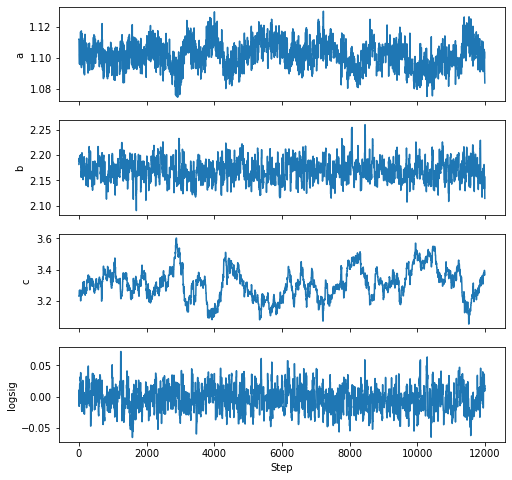

In [22]:
fig, axes = plt.subplots(nrows=nprms, sharex=True, figsize=(8,8))
for i, k in enumerate(prm_order):
    axes[i].plot(chain[k].T)
    axes[i].set_ylabel(k)
axes[nprms-1].set_xlabel('Step')

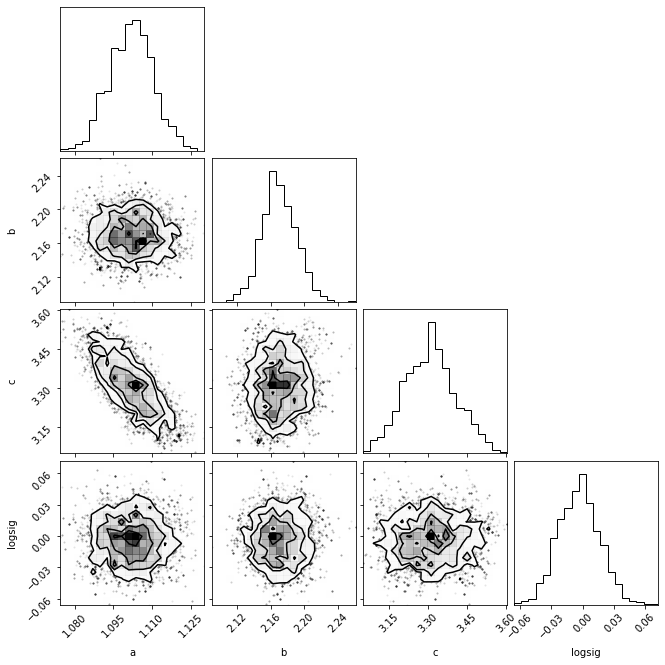

In [23]:
_ = corner.corner(chain)

Inferred noise sigma:   0.992
A:    1.1, B:   2.17, C:   3.31
Chi-sq: 2.48e+02, Reduced Chi-sq:    0.98


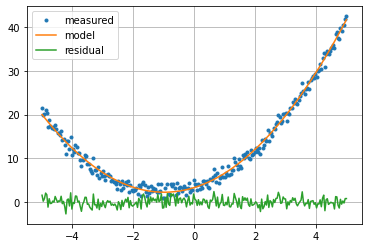

In [24]:
prms_opt = {k: np.mean(chain[k]) for k in prm_order}
sig_n = 10**prms_opt.pop('logsig')
print(f'Inferred noise sigma: {sig_n:7.3}')
report(prms_opt)